In [89]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [90]:
def sumsquare(x1, x2):
    return x1**2 + x2**2

In [91]:
t1 = torch.linspace(-20, 5, 100)
t2 = torch.linspace(-5, 20, 100)    

T1, T2 = torch.meshgrid(t1, t2, indexing='ij')

Z = sumsquare(T1, T2)

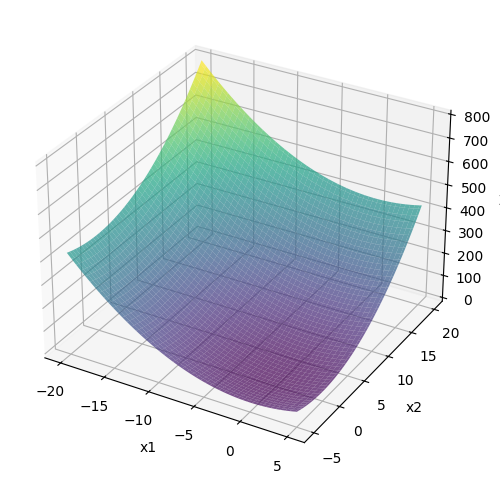

In [92]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T1, T2, Z, cmap='viridis', alpha=0.7)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Z')
plt.show()

In [93]:
primals = (torch.tensor([-18.]), torch.tensor([20.]))
primals

(tensor([-18.]), tensor([20.]))

In [94]:
rand_v = tuple([torch.rand_like(p) for p in primals])
rand_v

(tensor([0.0800]), tensor([0.2455]))

In [95]:
val, jvp = torch.func.jvp(sumsquare, primals, rand_v)
jvp

tensor([6.9415])

In [96]:
learning_rate = 1e-2
x_v = [p.sub_(learning_rate * jvp * rand_v[j]).item() for j, p in enumerate(primals)]
x_v

[-18.005550384521484, 19.98295783996582]

In [97]:
fwd_grads = [jvp * rand_v[j] for j, _ in enumerate(primals)]
fwd_grads

[tensor([0.5551]), tensor([1.7042])]

In [98]:
v_canonic = [tuple([torch.ones(p.shape) if i==j else torch.zeros(p.shape) for i, p in enumerate(primals)]) for j in range(len(primals))]
v_canonic

[(tensor([1.]), tensor([0.])), (tensor([0.]), tensor([1.]))]

In [99]:
true_grad = [torch.func.jvp(sumsquare, primals, v)[1].item() for v in v_canonic]
true_grad

[-36.01110076904297, 39.96591567993164]

100%|██████████| 3000/3000 [00:02<00:00, 1454.44it/s]


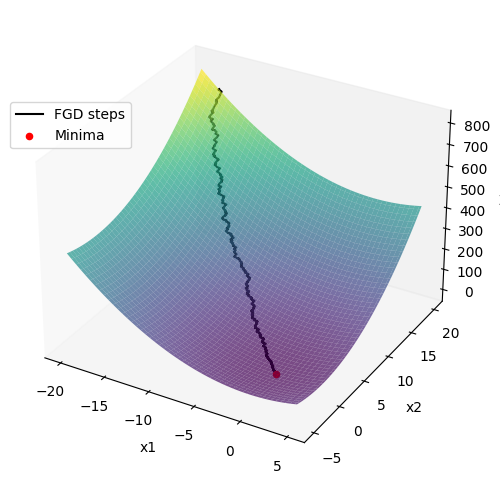

In [100]:
learning_rate = 1e-2
epochs = 3000

x_values = list()
y_values = list()
fwd_grads = list()
true_grads = list()

min = [0, 0 ,0]
primals = (torch.tensor([-18.]), torch.tensor([20.]))

# Perform FDG (forward gradient descent)
for i in tqdm(range(epochs)):
    # Sample perturbation
    v_params = tuple([torch.rand_like(p) for p in primals])
    # Compute f and df
    val, jvp = torch.func.jvp(sumsquare, primals, v_params)
    # Decay learning rate
    l_rate = learning_rate * np.exp(-i*1e-4)
    # Parameters update using forward gradient
    x_values.append([p.sub_(l_rate * jvp * v_params[j]).item() for j, p in enumerate(primals)])
    # Save true gradients, fwd gradients and "loss" values
    fwd_grads.append([jvp * v_params[j] for j, p in enumerate(primals)])
    true_grads.append([torch.func.jvp(sumsquare, primals, v)[1].item() for v in v_canonic])
    y_values.append(val)

x_values = torch.tensor(x_values)
fwd_grads = torch.tensor(fwd_grads)
true_grads = torch.tensor(true_grads)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.plot_surface(T1, T2, Z, cmap='viridis', alpha=0.7)
ax.plot(x_values[:, 0], x_values[:, 1], sumsquare(*x_values.T), '-', color='black', label="FGD steps", alpha=1)
ax.scatter(min[0], min[1], min[2], color='r', label='Minima')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Z')
ax.legend(loc=(0, 0.7))
plt.show()

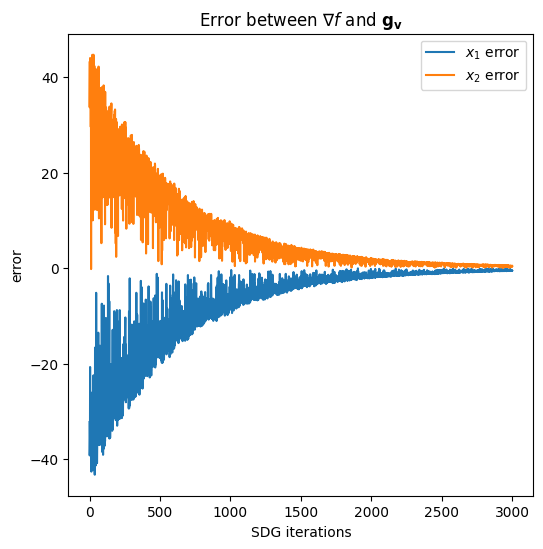

In [101]:
fig = plt.figure(figsize=(6, 6))
plt.plot(true_grads[:,0]-fwd_grads[:,0], label=r'$x_1$ error')
plt.plot(true_grads[:,1]-fwd_grads[:,1], label=r'$x_2$ error')
plt.title(r"Error between $\nabla f$ and $\mathbf{g}_\mathbf{v}$")
plt.xlabel(r'SDG iterations')
plt.ylabel('error')
plt.legend()
plt.show()